# 实验一
构建简单CNN实现Mnist手写数字数据集的分类

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

def get_params(model):
  np = 0
  for p in list(model.parameters()):
    np += p.nelement()
  return np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 加载数据
PyTorch里包含了 MNIST， CIFAR10 等常用数据集，调用 torchvision.datasets 即可把这些数据由远程下载到本地，下面给出MNIST的使用方法：

torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)

root 为数据集下载到本地后的根目录，包括 training.pt 和 test.pt 文件

train，如果设置为True，从training.pt创建数据集，否则从test.pt创建。

download，如果设置为True, 从互联网下载数据并放到root文件夹下

transform, 一种函数或变换，输入PIL图片，返回变换之后的数据。

target_transform 一种函数或变换，输入目标，进行变换。

另外值得注意的是，DataLoader是一个比较重要的类，提供的常用操作有：batch_size(每个batch的大小), shuffle(是否进行随机打乱顺序的操作), num_workers(加载数据的时候使用几个子进程)

In [ ]:
input_size = 28*28
output_size = 10

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:05<00:00, 1905305.23it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 804460.71it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1466150.68it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11928947.26it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



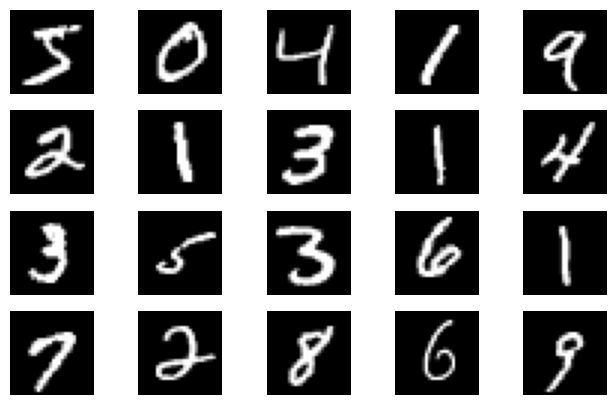

In [ ]:
plt.figure(figsize = (8,5))
for i in range(20):
  plt.subplot(4,5,i+1)
  img, _ = train_loader.dataset.__getitem__(i)
  plt.imshow(img.squeeze().numpy(),cmap = 'gray')
  plt.axis('off')

# 2.创建网络
定义网络时，需要继承nn.Module，并实现它的forward方法，把网络中具有可学习参数的层放在构造函数__init__中。

只要在nn.Module的子类中定义了forward函数，backward函数就会自动被实现(利用autograd)。

In [ ]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        # nn.Module子类的函数必须在构造函数中执行父类的构造函数
        # 下式等价于nn.Module.__init__(self)
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        # 这里直接用 Sequential 就定义了网络，注意要和下面 CNN 的代码区分开
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        # view一般出现在model类的forward函数中，用于改变输入或输出的形状
        # x.view(-1, self.input_size) 的意思是多维的数据展成二维
        # 代码指定二维数据的列数为 input_size=784，行数 -1 表示我们不想算，电脑会自己计算对应的数字
        # 在 DataLoader 部分，我们可以看到 batch_size 是64，所以得到 x 的行数是64
        # 大家可以加一行代码：print(x.cpu().numpy().shape)
        # 训练过程中，就会看到 (64, 784) 的输出，和我们的预期是一致的

        # forward 函数的作用是，指定网络的运行过程，这个全连接网络可能看不啥意义，
        # 下面的CNN网络可以看出 forward 的作用。
        x = x.view(-1, self.input_size)
        return self.network(x)



class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        # 执行父类的构造函数，所有的网络都要这么写
        super(CNN, self).__init__()
        # 下面是网络里典型结构的一些定义，一般就是卷积和全连接
        # 池化、ReLU一类的不用在这里定义
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)

    # 下面的 forward 函数，定义了网络的结构，按照一定顺序，把上面构建的一些结构组织起来
    # 意思就是，conv1, conv2 等等的，可以多次重用
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
# 训练函数
def train(model):
    model.train()
    # 主里从train_loader里，64个样本一个batch为单位提取样本进行训练
    for batch_idx, (data, target) in enumerate(train_loader):
        # 把数据送到GPU中
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # 把数据送到GPU中
        data, target = data.to(device), target.to(device)
        # 把数据送入模型，得到预测结果
        output = model(data)
        # 计算本次batch的损失，并加到 test_loss 中
        test_loss += F.nll_loss(output, target, reduction='sum').item()
        # get the index of the max log-probability，最后一层输出10个数，
        # 值最大的那个即对应着分类结果，然后把分类结果保存在 pred 里
        pred = output.data.max(1, keepdim=True)[1]
        # 将 pred 与 target 相比，得到正确预测结果的数量，并加到 correct 中
        # 这里需要注意一下 view_as ，意思是把 target 变成维度和 pred 一样的意思
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# 3.在小型全连接网络上训练

In [ ]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_params(model_fnn)))

train(model_fnn)
test(model_fnn)

Number of parameters: 6442
Train: [0/60000 (0%)]	Loss: 2.267809
Train: [6400/60000 (11%)]	Loss: 1.667629
Train: [12800/60000 (21%)]	Loss: 1.133887
Train: [19200/60000 (32%)]	Loss: 0.789954
Train: [25600/60000 (43%)]	Loss: 0.667085
Train: [32000/60000 (53%)]	Loss: 0.578891
Train: [38400/60000 (64%)]	Loss: 0.404739
Train: [44800/60000 (75%)]	Loss: 0.406378
Train: [51200/60000 (85%)]	Loss: 0.340552
Train: [57600/60000 (96%)]	Loss: 0.495622

Test set: Average loss: 0.3989, Accuracy: 8834/10000 (88%)



# 4.在CNN上训练

In [ ]:
# Training settings
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_params(model_cnn)))

train(model_cnn)
test(model_cnn)

Number of parameters: 6422
Train: [0/60000 (0%)]	Loss: 2.313729
Train: [6400/60000 (11%)]	Loss: 1.540867
Train: [12800/60000 (21%)]	Loss: 0.659880
Train: [19200/60000 (32%)]	Loss: 0.253553
Train: [25600/60000 (43%)]	Loss: 0.368782
Train: [32000/60000 (53%)]	Loss: 0.468929
Train: [38400/60000 (64%)]	Loss: 0.207900
Train: [44800/60000 (75%)]	Loss: 0.218204
Train: [51200/60000 (85%)]	Loss: 0.276357
Train: [57600/60000 (96%)]	Loss: 0.123874

Test set: Average loss: 0.1568, Accuracy: 9533/10000 (95%)



# 5.打乱像素顺序，重新在两个网络上训练
考虑到CNN在卷积与池化上的优良特性，如果我们把图像中的像素打乱顺序，这样 卷积 和 池化 就难以发挥作用了，为了验证这个想法，我们把图像中的像素打乱顺序再试试。

首先下面代码展示随机打乱像素顺序后，图像的形态：

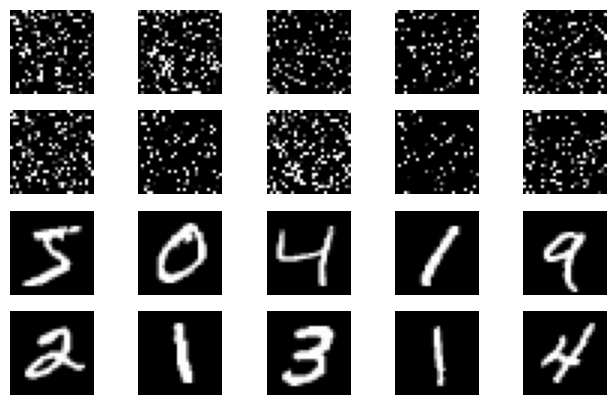

In [ ]:
perm = torch.randperm(784)
plt.figure(figsize = (8,5))
for i in range(10):
  img, _ = train_loader.dataset.__getitem__(i)

  img_perm = img.view(-1, 28*28).clone()
  img_perm = img_perm[:, perm]
  img_perm = img_perm.view(-1, 28, 28)
  plt.subplot(4,5,i+1)
  plt.imshow(img_perm.squeeze().numpy(),cmap = 'gray')
  plt.axis('off')
  plt.subplot(4,5,i+11)
  plt.imshow(img.squeeze().numpy(),cmap = 'gray')
  plt.axis('off')

In [ ]:
# 对每个 batch 里的数据，打乱像素顺序的函数
def perm_pixel(data, perm):
    # 转化为二维矩阵
    data_new = data.view(-1, 28*28)
    # 打乱像素顺序
    data_new = data_new[:, perm]
    # 恢复为原来4维的 tensor
    data_new = data_new.view(-1, 1, 28, 28)
    return data_new

# 训练函数
def train_perm(model, perm):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # 像素打乱顺序
        data = perm_pixel(data, perm)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# 测试函数
def test_perm(model, perm):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # 像素打乱顺序
        data = perm_pixel(data, perm)

        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [ ]:
perm = torch.randperm(784)
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_params(model_fnn)))

train_perm(model_fnn, perm)
test_perm(model_fnn, perm)

Number of parameters: 6442
Train: [0/60000 (0%)]	Loss: 2.276114
Train: [6400/60000 (11%)]	Loss: 1.977035
Train: [12800/60000 (21%)]	Loss: 1.208702
Train: [19200/60000 (32%)]	Loss: 0.766204
Train: [25600/60000 (43%)]	Loss: 0.572204
Train: [32000/60000 (53%)]	Loss: 0.502192
Train: [38400/60000 (64%)]	Loss: 0.519949
Train: [44800/60000 (75%)]	Loss: 0.381867
Train: [51200/60000 (85%)]	Loss: 0.450572
Train: [57600/60000 (96%)]	Loss: 0.397750

Test set: Average loss: 0.3996, Accuracy: 8857/10000 (89%)



In [ ]:
perm = torch.randperm(784)
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_params(model_cnn)))

train_perm(model_cnn, perm)
test_perm(model_cnn, perm)

Number of parameters: 6422
Train: [0/60000 (0%)]	Loss: 2.353731
Train: [6400/60000 (11%)]	Loss: 2.274198
Train: [12800/60000 (21%)]	Loss: 2.217433
Train: [19200/60000 (32%)]	Loss: 1.983218
Train: [25600/60000 (43%)]	Loss: 1.231610
Train: [32000/60000 (53%)]	Loss: 0.853280
Train: [38400/60000 (64%)]	Loss: 0.832802
Train: [44800/60000 (75%)]	Loss: 0.872526
Train: [51200/60000 (85%)]	Loss: 0.609364
Train: [57600/60000 (96%)]	Loss: 0.527641

Test set: Average loss: 0.5491, Accuracy: 8283/10000 (83%)



从打乱像素顺序的实验结果来看，全连接网络的性能基本上没有发生变化，但是 卷积神经网络的性能明显下降。

这是因为对于卷积神经网络，会利用像素的局部关系，但是打乱顺序以后，这些像素间的关系将无法得到利用。

# 实验二 搭建CNN完成CIFAR10分类

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 42350767.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


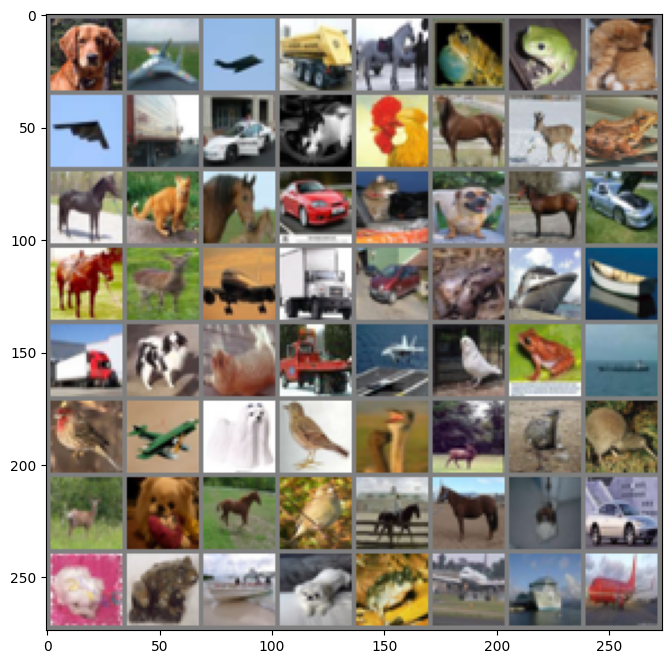

dog
plane
plane
truck
horse
frog
frog
cat


In [3]:
def imshow(img):
    plt.figure(figsize=(8,8))
    img = img / 2 + 0.5     # 转换到 [0,1] 之间
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 得到一组图像
images, labels = next(iter(trainloader))
# 展示图像
imshow(torchvision.utils.make_grid(images))
# 展示第一行图像的标签
for j in range(8):
    print(classes[labels[j]])

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 网络放到GPU上
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [10]:
for epoch in range(10):  # 重复多轮训练
    for i, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 优化器梯度归零
        optimizer.zero_grad()
        # 正向传播 +　反向传播 + 优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # 输出统计信息
    print('Epoch: %d Minibatch: %5d loss: %.3f' %(epoch + 1, i + 1, loss.item()))

print('Finished Training')

Epoch: 1 Minibatch:   782 loss: 0.661
Epoch: 2 Minibatch:   782 loss: 0.946
Epoch: 3 Minibatch:   782 loss: 0.685
Epoch: 4 Minibatch:   782 loss: 0.936
Epoch: 5 Minibatch:   782 loss: 0.623
Epoch: 6 Minibatch:   782 loss: 0.757
Epoch: 7 Minibatch:   782 loss: 0.744
Epoch: 8 Minibatch:   782 loss: 1.036
Epoch: 9 Minibatch:   782 loss: 0.991
Epoch: 10 Minibatch:   782 loss: 0.649
Finished Training


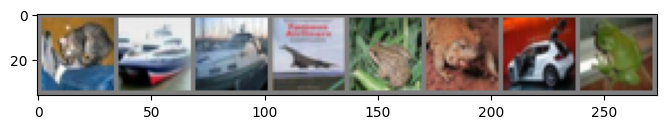

cat
ship
ship
plane
frog
frog
car
frog


In [11]:
# 得到一组图像
images, labels = next(iter(testloader))
# 展示图像
imshow(torchvision.utils.make_grid(images))
# 展示图像的标签
for j in range(8):
    print(classes[labels[j]])

In [12]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

# 展示预测的结果
for j in range(8):
    print(classes[predicted[j]])

cat
ship
ship
plane
deer
frog
car
frog


In [13]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


# 实验三 VGG16对CIFAR10进行分类

VGG是由Simonyan 和Zisserman在文献《Very Deep Convolutional Networks for Large Scale Image Recognition》中提出卷积神经网络模型，其名称来源于作者所在的牛津大学视觉几何组(Visual Geometry Group)的缩写。
16层网络的结节信息如下：


*   01：Convolution using 64 filters
*   02: Convolution using 64 filters + Max pooling
*   03: Convolution using 128 filters
*   04: Convolution using 128 filters + Max pooling
*   05: Convolution using 256 filters
*   06: Convolution using 256 filters
*   07: Convolution using 256 filters + Max pooling
*   08: Convolution using 512 filters
*   09: Convolution using 512 filters
*   10: Convolution using 512 filters + Max pooling
*   11: Convolution using 512 filters
*   12: Convolution using 512 filters
*   13: Convolution using 512 filters + Max pooling
*   14: Fully connected with 4096 nodes
*   15: Fully connected with 4096 nodes
*   16: Softmax

## 1.定义dataloader

In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform_train)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
device

Files already downloaded and verified
Files already downloaded and verified


device(type='cuda', index=0)

定义VGG网络结构

In [24]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.cfg = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
        self.features = self._make_layers(self.cfg)
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [25]:
net = VGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [26]:
for epoch in range(10):  # 重复多轮训练
    for i, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 优化器梯度归零
        optimizer.zero_grad()
        # 正向传播 +　反向传播 + 优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # 输出统计信息
        if i % 100 == 0:
            print('Epoch: %d Minibatch: %5d loss: %.3f' %(epoch + 1, i + 1, loss.item()))

print('Finished Training')

Epoch: 1 Minibatch:     1 loss: 2.621
Epoch: 1 Minibatch:   101 loss: 1.599
Epoch: 1 Minibatch:   201 loss: 1.181
Epoch: 1 Minibatch:   301 loss: 1.007
Epoch: 2 Minibatch:     1 loss: 1.008
Epoch: 2 Minibatch:   101 loss: 1.230
Epoch: 2 Minibatch:   201 loss: 0.873
Epoch: 2 Minibatch:   301 loss: 0.875
Epoch: 3 Minibatch:     1 loss: 0.961
Epoch: 3 Minibatch:   101 loss: 0.716
Epoch: 3 Minibatch:   201 loss: 0.831
Epoch: 3 Minibatch:   301 loss: 0.794
Epoch: 4 Minibatch:     1 loss: 0.670
Epoch: 4 Minibatch:   101 loss: 0.819
Epoch: 4 Minibatch:   201 loss: 0.770
Epoch: 4 Minibatch:   301 loss: 0.718
Epoch: 5 Minibatch:     1 loss: 0.587
Epoch: 5 Minibatch:   101 loss: 0.524
Epoch: 5 Minibatch:   201 loss: 0.593
Epoch: 5 Minibatch:   301 loss: 0.588
Epoch: 6 Minibatch:     1 loss: 0.457
Epoch: 6 Minibatch:   101 loss: 0.615
Epoch: 6 Minibatch:   201 loss: 0.647
Epoch: 6 Minibatch:   301 loss: 0.657
Epoch: 7 Minibatch:     1 loss: 0.681
Epoch: 7 Minibatch:   101 loss: 0.607
Epoch: 7 Min

In [27]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 82.94 %
